In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

## Read and Clean Datasets

In [2]:
    beni = pd.read_csv('Datasets/health/train_beni_sample.csv')
columns_to_drop = ['NoOfMonths_PartACov', 'NoOfMonths_PartBCov','IPAnnualReimbursementAmt',
                  'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
                   'OPAnnualDeductibleAmt','DOD','DOB']
print("Benificiary: ", beni.shape)

Benificiary:  (138556, 25)


In [3]:
labels = pd.read_csv('Datasets/health/train_labels.csv')
print("Labels: ",labels.shape)

Labels:  (5410, 2)


In [4]:
outpatient = pd.read_csv('Datasets/health/train_outpatient_sample.csv')
print('Outpatient: ',outpatient.shape)

Outpatient:  (517737, 27)


## Inspect the % and the total count of fraudulent/none-fraudulent cases

In [5]:
def merge_datasets(main_df, patients, labels, cols_to_drop = None):
    df = main_df.drop(cols_to_drop,axis=1)
    df = df.merge(patients,on='BeneID',)
    df = df.merge(labels,on='Provider')
    df = df.drop(['BeneID','Provider'],axis=1)   
    return df


out_cols_to_drop = ['ClaimID','ClaimStartDt','ClaimEndDt',
                'InscClaimAmtReimbursed','DeductibleAmtPaid']

out_df = merge_datasets(outpatient,beni,labels,out_cols_to_drop)
out_fname ='Results/Outpatients/outpatient'

##### Visualization 001

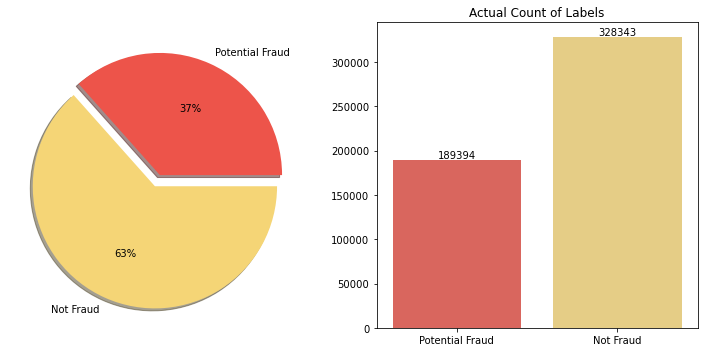

In [6]:
# Fradulant and None Fraudlant
fig,axes = plt.subplots(1,2,figsize=(10,5))

ttl_data= [out_df['PotentialFraud'].value_counts().Yes, 
           out_df['PotentialFraud'].value_counts().No]

labels = ['Potential Fraud','Not Fraud']
palette = ['#ed544a','#f5d576']
explode = (0, 0.1) 

axes[0].pie(ttl_data, labels=labels,
            colors = palette,
            autopct = '%0.0f%%',shadow=True,explode=explode)

sns.barplot(x=labels,y=ttl_data,palette=palette,ax=axes[1])

axes[1].set_title("Actual Count of Labels")
axes[1].bar_label(container=axes[1].containers[0], labels=list(ttl_data))
plt.tight_layout()
plt.savefig(f'{out_fname}_FraudLabelDistribution-001.png')

## 

## <font color='red'>Do patients' chronic conditions provide sufficient information to distinguish fraud records?</font>

In [7]:
from sklearn.decomposition import TruncatedSVD
from itertools import combinations

In [8]:
# 12 Different Chronic Conditions
def create_condition_matrix(outpatient_df):
    chronic_condition = [col for col in outpatient_df.columns 
                         if col.startswith('ChronicCond') or col == 'PotentialFraud']
    
    chronic_condition_matrix = outpatient_df[chronic_condition].set_index('PotentialFraud')
    chronic_condition_matrix = chronic_condition_matrix.subtract(1)
    
    return chronic_condition_matrix,chronic_condition


def fit_SVD(chronic_condition_matrix,chronic_condition):
    
    explained_var = []
    for i in range(2,len(chronic_condition)-1):
        chronic_svd = TruncatedSVD(n_components=i,random_state=101)
        chronic_svd.fit(chronic_condition_matrix)
        variance = chronic_svd.explained_variance_ratio_
        explained_var.append(np.sum(variance))
        
    return explained_var
        


# chronic_condition_matrix,chronic_condition = create_condition_matrix(out_df)
# explained_var = fit_SVD(chronic_condition_matrix,chronic_condition)

# sns.lineplot(x = [i for i in range(2,len(chronic_condition)-1)],y=explained_var)
# sns.scatterplot(x = [i for i in range(2,len(chronic_condition)-1)],y=explained_var,color='red')
# plt.xlabel('# of Component')
# plt.ylabel('Explanied Variance')
# plt.axhline(y=0.9,c='green',ls='--',lw=2)
# plt.title('Choosing # of SVD components')
# # plt.savefig(f'{out_fname}_choosing N components.png')
# plt.show()

In [9]:
# # Inspect each components distribution and compare based on fraud/none-fraud labels
# chronic_svd = TruncatedSVD(n_components = 9,random_state=101)
# chronic_svd.fit(chronic_condition_matrix)
# ans = chronic_svd.transform(chronic_condition_matrix)
# column_names = [f'SVD_{idx}' for idx in range(1,10)]
# test = pd.DataFrame(ans,columns=column_names)
# test['lbl'] = chronic_condition_matrix.index

# for col in test.columns[:-1]:
#     fig,axes = plt.subplots(1,2,figsize=(15,5))
#     plt.suptitle(f"Fraudulent Concept VS None Fraudulent Concept")
    
#     sns.violinplot(data = test,x=f'{col}',y='lbl'
#                    ,palette=palette,ax=axes[0])
    
#     sns.histplot(data = test,x=f'{col}',hue='lbl',
#                  bins=20,kde=True, palette=palette,ax=axes[1])
    
# #     plt.savefig(f'{out_fname}_{col}.png')
#     plt.tight_layout()
#     plt.show()

In [10]:
# # Could any two components possibly provide more insights?
# for i in combinations(test,2):
#     if 'lbl' in i:
#         pass
#     else:
#         plt.title(f'{i}')
#         sns.scatterplot(data=test.sample(frac=0.2,random_state=101),
#                         x=f"{i[0]}",y=f"{i[1]}",hue='lbl',palette=palette)
# #         plt.savefig(f'{out_fname}_scatter_SVD_2D_pairs_{i}.png')
#         plt.show()

## 

## <font color='red'> Can we find any difference in chronic condition itemsets based on fraud/non-fraud labels?  </font>

In [11]:
from mlxtend.frequent_patterns import apriori

In [12]:
def top_n_itemsets(df,support,top_n):
    matrix,chronic_cols = create_condition_matrix(df)
    chronic_itemsets = apriori(matrix,min_support=support,use_colnames=True)
    chronic_itemsets = chronic_itemsets[chronic_itemsets.itemsets.apply(lambda x:len(x)) > 1]
    top_n_itemsets = chronic_itemsets.sort_values(by='support',ascending=False).nlargest(top_n,columns='support')
    top_n_itemsets = top_n_itemsets.reset_index(drop=True)
    
    return top_n_itemsets

In [13]:
pos_top10_condition= top_n_itemsets(out_df[out_df.PotentialFraud == 'Yes'],0.5,10)
neg_top10_condition = top_n_itemsets(out_df[out_df.PotentialFraud == 'No'],0.5,10)
merge_results = pos_top10_condition.merge(neg_top10_condition,how='left',on='itemsets')
merge_results.columns = ['None Fraudulent','itemsets','Fraudulent']
merge_results = merge_results[['itemsets','Fraudulent','None Fraudulent']]
merge_results.columns = ['itemsets','Fraudulent %','None Fraudulent %']
merge_results

,itemsets,Fraudulent %,None Fraudulent %
0,"(ChronicCond_stroke, ChronicCond_Cancer)",0.774334,0.772818
1,"(ChronicCond_stroke, ChronicCond_ObstrPulmonary)",0.649455,0.649466
2,"(ChronicCond_stroke, ChronicCond_rheumatoidart...",0.635384,0.633552
3,"(ChronicCond_stroke, ChronicCond_Osteoporasis)",0.624505,0.625543
4,"(ChronicCond_ObstrPulmonary, ChronicCond_Cancer)",0.614388,0.613853
5,"(ChronicCond_rheumatoidarthritis, ChronicCond_...",0.599574,0.598324
6,"(ChronicCond_Osteoporasis, ChronicCond_Cancer)",0.590300,0.592627
7,"(ChronicCond_stroke, ChronicCond_ObstrPulmonar...",0.571987,0.571755
8,"(ChronicCond_stroke, ChronicCond_Alzheimer)",0.566502,0.565762
9,"(ChronicCond_stroke, ChronicCond_KidneyDisease)",0.566974,0.563476


In [14]:
# out_df.sample(100).to_csv('merged_outpatient_dataset_sample.csv',index=0)

## 

## <font color='purple'>Can we identify Physicians who regularly engaged in Fraudulent activities?</font>

In [15]:
def get_physicians(df):
    physician = [col for col in df.columns 
                 if col.endswith('Physician') or col == 'PotentialFraud']
    
    phy_df = df[physician].fillna('None')
    uni_phy = set()

    for col in phy_df.columns:
        uni_phy.update(set(phy_df[col]))

    uni_phy = dict.fromkeys(uni_phy,0)
    
    return phy_df,uni_phy


In [16]:
## Check the overlaps of two subgroups (Engage in Fraudulent or None)
# Sanity Check: 
# Physicians who frequently conduct in fraud are expected to have 0 or less records in None-Fraudulent Records

# Those who appeared in a fraudulent record
phy_df, uni_phy_keys = get_physicians(out_df)
for idx in range(len(phy_df)):
    record = phy_df.iloc[idx].values
    at_phy,op_phy,ot_phy,lbl = record
    
    if lbl == 'Yes':
        if at_phy != 'None':
            uni_phy_keys[at_phy] += 1
            
        if op_phy != 'None':
            uni_phy_keys[op_phy] += 1
            
        if ot_phy != 'None':
            uni_phy_keys[ot_phy] += 1

            
# Drop physicians who have no fraud engagement record
# Create an engagement index for later calculation of Tiers
phy_in_fraud = sorted(uni_phy_keys.items(),key=lambda x: x[1],reverse=True)
phy_in_fraud = list(filter(lambda x: x[1] > 0, phy_in_fraud))
phy_in_fraud = pd.DataFrame(phy_in_fraud,columns=['Physician_ID','Cnt_Fraud_Engagement'])
phy_in_fraud['Cnt_Fraud_Engagement_Rate'] = np.round((phy_in_fraud['Cnt_Fraud_Engagement'] / ttl_data[1]) * 100 , 2)
phy_in_fraud.head()


# Those who did not appear in a fraudulent record
phy_df, uni_phy_keys_none_fraud = get_physicians(out_df)

for idx in range(len(phy_df)):
    record = phy_df.iloc[idx].values
    at_phy,op_phy,ot_phy,lbl = record
    
    if lbl == 'No':
        if at_phy != 'None':
            uni_phy_keys_none_fraud[at_phy] += 1
            
        if op_phy != 'None':
            uni_phy_keys_none_fraud[op_phy] += 1
            
        if ot_phy != 'None':
            uni_phy_keys_none_fraud[ot_phy] += 1

# Drop physicians who have no fraud engagement record
# Create an engagement index for later calculation of Tiers
phy_nin_fraud = sorted(uni_phy_keys_none_fraud.items(),key=lambda x: x[1],reverse=True)
phy_nin_fraud = list(filter(lambda x: x[1] > 0, phy_nin_fraud))
phy_nin_fraud = pd.DataFrame(phy_nin_fraud,columns=['Physician_ID','Cnt_Fraud_Engagement'])
phy_nin_fraud['Cnt_Fraud_Engagement_Rate'] = np.round((phy_nin_fraud['Cnt_Fraud_Engagement'] / ttl_data[1]) * 100 , 2)

# phy_in_fraud.to_csv('physicians_found_in_fraud_records.csv',index=0)
# phy_nin_fraud.to_csv('physicians_not_found_in_fraud_records.csv',index=0)


# proof_phy_unique = phy_in_fraud.merge(phy_nin_fraud,how='outer',on='Physician_ID')
# proof_phy_unique = proof_phy_unique.drop(['Cnt_Fraud_Engagement_Rate_x','Cnt_Fraud_Engagement_Rate_y'],axis=1)
# proof_phy_unique.head(100)

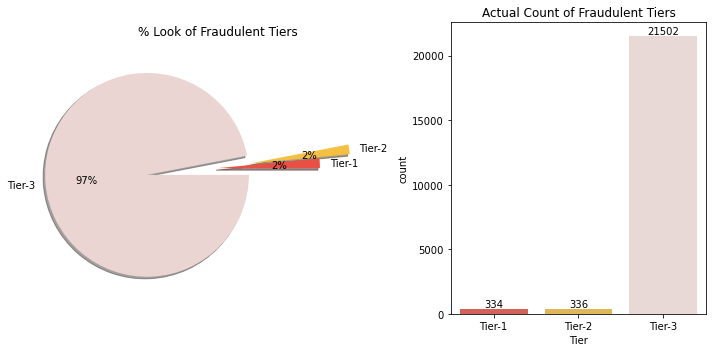

In [17]:
## How bad is the situation of fraud engagement
def tier_categorizer(value):
    if value >= eng_mean + 2 * eng_std:
        return 'Tier-1'
    elif (value < eng_mean + 2 * eng_std) & (value > eng_mean + 1 * eng_std):
        return 'Tier-2'
    else:
        return 'Tier-3'
    
eng_mean   = np.mean(phy_in_fraud['Cnt_Fraud_Engagement_Rate'])
eng_std    = np.std(phy_in_fraud['Cnt_Fraud_Engagement_Rate'])
phy_in_fraud['Tier'] = phy_in_fraud['Cnt_Fraud_Engagement_Rate'].apply(tier_categorizer)


fig,axes = plt.subplots(1,2,figsize=(10,5))
data = phy_in_fraud['Tier'].value_counts(ascending=True).values
labels = list(phy_in_fraud.Tier.unique())
explode = (0, 0.3,0.7) 
axes[0].set_title("% Look of Fraudulent Tiers")
axes[0].pie(data, labels=labels,
            colors = ['#e85046','#f5bf42','#ebd5d3'], 
            autopct = '%0.0f%%',shadow=True,explode=explode)

sns.countplot(data = phy_in_fraud, x='Tier',ax=axes[1],palette = ['#e85046','#f5bf42','#ebd5d3'])

axes[1].set_title("Actual Count of Fraudulent Tiers")
axes[1].bar_label(container=axes[1].containers[0], labels=list(data))
plt.tight_layout()
# plt.savefig(f'{out_fname}_Fraud_Engagement_Percentage.png')

# 

## <font color='purple'>Can we further identify Physicians who regularly engaged in Fraudulent activities in terms of groups?</font>

In [18]:
from sklearn.preprocessing import MultiLabelBinarizer
from pyvis.network import Network
import networkx as nx

In [19]:
def get_phy_itemsets(df,window_size = 1000, min_support=0.05):
    physician = [col for col in df.columns 
                 if col.endswith('Physician') or col == 'PotentialFraud']
    
    phy_itemset = df[physician][['AttendingPhysician','OperatingPhysician','OtherPhysician']]
    phy_itemset = phy_itemset.fillna('None').values
    mlb = MultiLabelBinarizer()
    mlb.fit(phy_itemset)
    
    # Split data and accumulate itemsets results
    window = window_size
    place_holder = pd.DataFrame(columns=['support','itemsets'])

    for i in range(0,len(phy_itemset),window):
        print(i,end='\r')
        itemsets = pd.DataFrame(mlb.transform(phy_itemset[i:i+window]),columns=mlb.classes_)
        itemsets.drop('None',axis=1,inplace=True)
        freq_phy_itemsets = apriori(itemsets,min_support=min_support,use_colnames=True)

        place_holder = pd.concat([place_holder,freq_phy_itemsets],ignore_index=True)
        
    return place_holder

# Create Frequent itemsets of length two
freq_phy_itemsets = get_phy_itemsets(out_df,window_size=2000,min_support=0.025)
freq_phy_itemsets = freq_phy_itemsets[freq_phy_itemsets.itemsets.apply(lambda x:len(x)) == 2]
freq_phy_itemsets = freq_phy_itemsets.groupby('itemsets').aggregate(np.mean)

# Prepare frequent itemsets for Knowlegde Graph Construction
two_freq_phy_itemsets = freq_phy_itemsets.sort_values(by='support',ascending=True)
two_freq_phy_itemsets = two_freq_phy_itemsets.reset_index()
two_freq_phy_itemsets['itemsets'] = two_freq_phy_itemsets['itemsets'].apply(list)
two_freq_phy_itemsets['A'] = two_freq_phy_itemsets['itemsets'].apply(lambda x: x[0])
two_freq_phy_itemsets['B'] = two_freq_phy_itemsets['itemsets'].apply(lambda x: x[1])

In [20]:
# two_freq_phy_itemsets.to_csv('frequent_physician_patterns.csv',index=0)

In [21]:
# Draw Graph
phy_graph = two_freq_phy_itemsets.drop('itemsets',axis=1)
phy_graph['support'] = phy_graph['support'] * 100
phy_nodes = set(list(phy_graph['A']) +  list(phy_graph['B']))
nx_graph = nx.star_graph(n = phy_nodes,create_using=nx.MultiGraph())

# Remove physicians who are not found in phy_in_fraud dataframe
"""
The purpose of this step is to remove physicians who are innocent 
but work closely with physicians who frequently engage in fraud activities
"""
nodes_to_remove = []
for node in nx_graph.nodes:
    row = phy_in_fraud[phy_in_fraud['Physician_ID'] == node]
    
    if len(row) == 0:
        nodes_to_remove.append(node)
        pass
    
    else:
        if row['Tier'].values == 'Tier-1':
            nx_graph.add_node(node,color='red')
            
        elif row['Tier'].values == 'Tier-2':
            nx_graph.add_node(node,color='#f5bf42')
            
        elif row['Tier'].values == 'Tier-3':
            nx_graph.add_node(node,color='#42ecf5')
            

            
# Clear Edge connections
nx_graph.remove_edges_from(list(nx_graph.edges()))

# Redifine Edge Connections
for support,a,b in phy_graph.values:
    nx_graph.add_edge(a,b,weight = np.round(support,2))

# Remove unwanted nodes
nx_graph.remove_nodes_from(nodes_to_remove)

# Draw Graph
nt = Network('800px', '800px',notebook=True)
nt.from_nx(nx_graph,show_edge_weights=False)
# nt.show(f'{out_fname}_knowledge_graph_phy_fraud_subgroups.html')

In [22]:
# phy_in_fraud[phy_in_fraud['Physician_ID'] == 'PHY396267']

## 

## <font color='green'>Do diagnosis codes provide sufficient information to distinguish fraud events?</font>

In [23]:
def get_claimD(df):
    claimD_cols = [col for col in df.columns 
                   if col.startswith('ClmDiagnosis') or col == 'PotentialFraud']
    claimD_df = df[claimD_cols]
    claimD_df = claimD_df.fillna('None')
    
    uni_claim = set()
    for col in claimD_df.columns[:-1]:
        uni_claim.update(set(claimD_df[col]))

    uni_claim = dict.fromkeys(uni_claim,0)

    pos_uni_claim = uni_claim.copy()
    neg_uni_claim = uni_claim.copy()

    for idx in range(len(claimD_df)):
        record = claimD_df.iloc[idx].values

        if 'Yes' in record:
            for item in record[:-1]:
                if item != 'None':
                    pos_uni_claim[item] += 1

        elif 'No' in record:
            for item in record[:-1]:
                if item != 'None':
                    neg_uni_claim[item] += 1
                    
    return pos_uni_claim, neg_uni_claim

clmD_in_fraud_pos, clmD_in_fraud_neg = get_claimD(out_df)

### Pos
clmD_in_fraud_pos = sorted(clmD_in_fraud_pos.items(),key=lambda x: x[1],reverse=True)
clmD_in_fraud_pos = list(filter(lambda x: x[1] > 0 ,clmD_in_fraud_pos))
clmD_in_fraud_pos = pd.DataFrame(clmD_in_fraud_pos,columns=['Claim_ID','Cnt_Fraud_Engagement'])

### Neg
clmD_in_fraud_neg = sorted(clmD_in_fraud_neg.items(),key=lambda x: x[1],reverse=True)
clmD_in_fraud_neg = list(filter(lambda x: x[1] > 0 ,clmD_in_fraud_neg))
clmD_in_fraud_neg = pd.DataFrame(clmD_in_fraud_neg,columns=['Claim_ID','Cnt_Fraud_Engagement'])

### Merge
clmD_eng_cnt = clmD_in_fraud_pos.merge(clmD_in_fraud_neg,how='left',on='Claim_ID')
clmD_eng_cnt = clmD_eng_cnt.head(10)
clmD_eng_cnt = clmD_eng_cnt.melt(id_vars='Claim_ID',var_name='posX_negY')
clmD_eng_cnt['posX_negY'] = clmD_eng_cnt['posX_negY'].map(
                                {'Cnt_Fraud_Engagement_x': 'Fraud',
                               'Cnt_Fraud_Engagement_y': 'Not Fraud'})

## 

## <font color='green'>Do procedure codes provide sufficient information to distinguish fraud events?</font>

In [24]:
# def get_claimP(df):
#     claimP_cols = [col for col in df.columns 
#                    if col.startswith('ClmProcedure') or col == 'PotentialFraud']
#     claimP_df = df[claimP_cols]
#     claimP_df = claimP_df.fillna('None')    
    
#     uni_claim = set()
#     for col in claimP_df.columns[:-1]:
#         uni_claim.update(set(claimP_df[col]))

#     uni_claim = dict.fromkeys(uni_claim,0)

#     pos_uni_claim = uni_claim.copy()
#     neg_uni_claim = uni_claim.copy()
    
#     for idx in range(len(claimP_df)):
#         record = claimP_df.iloc[idx].values

#         if 'Yes' in record:
#             for item in record[:-1]:
#                 if item != 'None':
#                     pos_uni_claim[item] += 1

#         elif 'No' in record:
#             for item in record[:-1]:
#                 if item != 'None':
#                     neg_uni_claim[item] += 1
                    
#     return pos_uni_claim, neg_uni_claim


# clmP_in_fraud_pos,clmP_in_fraud_neg = get_claimP(out_df)

# ### Pos
# clmP_in_fraud_pos = sorted(clmP_in_fraud_pos.items(),key=lambda x: x[1],reverse=True)
# clmP_in_fraud_pos = list(filter(lambda x: x[1] > 0 ,clmP_in_fraud_pos))
# clmP_in_fraud_pos = pd.DataFrame(clmP_in_fraud_pos,columns=['Claim_ID','Cnt_Fraud_Engagement'])

# ### Neg
# clmP_in_fraud_neg = sorted(clmP_in_fraud_neg.items(),key=lambda x: x[1],reverse=True)
# clmP_in_fraud_neg = list(filter(lambda x: x[1] > 0 ,clmP_in_fraud_neg))
# clmP_in_fraud_neg = pd.DataFrame(clmP_in_fraud_neg,columns=['Claim_ID','Cnt_Fraud_Engagement'])

# ### Merge
# clmP_eng_cnt = clmP_in_fraud_pos.merge(clmP_in_fraud_neg,how='left',on='Claim_ID')
# clmP_eng_cnt = clmP_eng_cnt.head(10)
# clmP_eng_cnt = clmP_eng_cnt.melt(id_vars='Claim_ID',var_name='posX_negY')
# clmP_eng_cnt['posX_negY'] = clmP_eng_cnt['posX_negY'].map({'Cnt_Fraud_Engagement_x': 'Fraud',
#                                'Cnt_Fraud_Engagement_y': 'Not Fraud'})
# clmP_eng_cnt['Claim_ID'] = clmP_eng_cnt['Claim_ID'].astype(int)

In [25]:
# fig,axes = plt.subplots(1,2,figsize=(10,5))

# sns.barplot(data=clmD_eng_cnt, y = 'value',x='Claim_ID',hue = 'posX_negY',
#             ax=axes[0],palette=['#ed544a','#f5d576'])

# axes[0].set_title("Diagnosis Code")
# axes[0].tick_params(axis='x', labelrotation = 45)


# sns.barplot(data=clmP_eng_cnt, y = 'value',x='Claim_ID',hue = 'posX_negY',
#             ax=axes[1],palette=['#ed544a','#f5d576'])
# axes[1].set_title("Procedure Code")
# axes[1].tick_params(axis='x', labelrotation = 45)

# plt.tight_layout()
# # plt.savefig(f'{out_fname}_DiagnosisProcedureCode.png')
# plt.show()